In [2]:
from nilearn import image
from nilearn.maskers import NiftiMasker
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy as np
import nibabel as nib
import pandas as pd
import os,glob
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Make Matrix

In [3]:
#load subject matrix
def load_matrix():
    data = loadmat('/Volumes/Cingulate/Sweetspot_Seg/subject_matrix.mat')
    first_matrix = data['first_matrix']
    masker = NiftiMasker(mask_img='/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/binary_zones1-2_n-map.nii.gz', standardize=True)
    mask_nii = masker.fit()
    return mask_nii, first_matrix

#index matrix and df by cohort
def matrix_df_selection(first_matrix,df_array,volume_array):
    ranges = [(0, 3), (4, 5), (6, 18), (19, 21), (22, 25), (26, 27), (28, 29), (30, 32), (32, 33), (34, 37), (38, 39), (40, 47)]
    second_matrix,df_selection,volume_selection = first_matrix.copy(),df_array.copy(),volume_array.copy()
    
    #make cohort matricies
    cingulotomy_rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    cingulotomy_matrix = second_matrix[cingulotomy_rows]
    cap_sct_matrix = np.delete(second_matrix,cingulotomy_rows,axis=0)
    
    #make clinical outcomes and volume cohorts
    cingulotomy_co = df_selection[cingulotomy_rows]
    cap_sct_co = np.delete(df_selection,cingulotomy_rows, axis=0)
    
    cingulotomy_volume = volume_selection[cingulotomy_rows]
    cap_sct_volume = np.delete(volume_selection,cingulotomy_rows, axis=0)
    
    return cingulotomy_matrix, cap_sct_matrix, cingulotomy_co, cap_sct_co, cingulotomy_volume, cap_sct_volume

df = pd.read_csv('/Volumes/Cingulate/Sweetspot_Seg/All_YBOCS_Vol_Cohort.csv')
df_array = df['Relative'].to_numpy().reshape(-1, 1) #change for absolute vs relative
volume_array = df['Volume'].to_numpy().reshape(-1,1) #volume

mask_nii, first_matrix = load_matrix()
cingulotomy_matrix, cap_sct_matrix, cingulotomy_co, cap_sct_co, cingulotomy_volume, cap_sct_volume = matrix_df_selection(first_matrix,df_array,volume_array)

# Generate Sweetspot

In [4]:
def sweetspot(matrix):
    #pearson and spearman correlations of matrix and clinical outcomes
    def correlations(A, B,path,export=False):
        n = A.shape[1]
        dist = stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        v_pear_r, v_pear_p, v_spear_r, v_spear_p = None, None, None, None
        A[np.isnan(A)],B[np.isnan(B)] = 0,0 #make nans 0
        if corr_type == 'pearson' or corr_type == 'both':
            A_mA = A - A.mean(1)[:, None]
            B_mB = B - B.mean(1)[:, None]
            ssA = (A_mA**2).sum(1)
            ssB = (B_mB**2).sum(1)
            v_pear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))).ravel()
            v_pear_p = 2*dist.cdf(-abs(v_pear_r))
            v_pear_p = np.around(v_pear_p, 200)
            v_pear_r[np.isnan(v_pear_r)],v_pear_p[np.isnan(v_pear_p)] = 0,0 #replace nans with 0s
            pos_v_pear_r = v_pear_r.copy()
            pos_v_pear_r[pos_v_pear_r < 0] = 0
        if corr_type == 'spearman' or corr_type == 'both':
            rank_A = np.apply_along_axis(lambda x: stats.rankdata(x, method='average'), 1, A) #ranking
            rank_B = np.apply_along_axis(lambda x: stats.rankdata(x, method='average'), 1, B)
            A_mA = rank_A - rank_A.mean(1)[:, None]
            B_mB = rank_B - rank_B.mean(1)[:, None]
            ssA = (A_mA**2).sum(1)
            ssB = (B_mB**2).sum(1)
            v_spear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))).ravel()
            v_spear_p = 2 * dist.cdf(-np.abs(v_spear_r))
            v_spear_p = np.around(v_spear_p, 200)
            v_spear_r[np.isnan(v_spear_r)],v_spear_p[np.isnan(v_spear_p)] = 0,0 #replace nans with 0s
            pos_v_spear_r = v_spear_r.copy()
            pos_v_spear_r[pos_v_spear_r < 0] = 0
        
        if export:
            if corr_type == 'pearson' or corr_type == 'both':
                nib.save(mask_nii.inverse_transform(v_pear_r.reshape(1, -1)), f'{path}/pearson_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(v_pear_p.reshape(1, -1)), f'{path}/pearson_p-map_from_r.nii.gz'),nib.save(mask_nii.inverse_transform(pos_v_pear_r.reshape(1, -1)), f'{path}/positive_pearson_r-map.nii.gz')
            if corr_type == 'spearman' or corr_type == 'both':
                nib.save(mask_nii.inverse_transform(v_spear_r.reshape(1, -1)), f'{path}/spearman_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(v_spear_p.reshape(1, -1)), f'{path}/spearman_p-map_from_r.nii.gz'),nib.save(mask_nii.inverse_transform(pos_v_spear_r.reshape(1, -1)), f'{path}/positive_spearman_r-map.nii.gz')
        return v_pear_r,v_pear_p,pos_v_pear_r,v_spear_r,v_spear_p,pos_v_spear_r

    #make r and p maps only where significant p < 0.05
    def significant(path, corr_type, v_pear_r, v_pear_p, v_spear_r, v_spear_p, export=False):
        sig_pearson_r_map, sig_pearson_p_map, sig_spearman_r_map, sig_spearman_p_map = None, None, None, None
        if corr_type == 'pearson' or corr_type == 'both':
            sig_pearson_mask = (v_pear_p > 0) & (v_pear_p <= 0.05)
            sig_pearson_r_map = v_pear_r * sig_pearson_mask
            sig_pearson_p_map = v_pear_p * sig_pearson_mask
            pos_sig_pearson_r = sig_pearson_r_map.copy()
            pos_sig_pearson_r[pos_sig_pearson_r < 0] = 0
            if export:
                nib.save(mask_nii.inverse_transform(sig_pearson_r_map.reshape(1, -1)), f'{path}/pearson_sig_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(sig_pearson_p_map.reshape(1, -1)), f'{path}/pearson_sig_p-map.nii.gz'),nib.save(mask_nii.inverse_transform(pos_sig_pearson_r.reshape(1, -1)), f'{path}/positive_pearson_sig_r-map.nii.gz')
      
        if corr_type == 'spearman' or corr_type == 'both':
            sig_spearman_mask = (v_spear_p > 0) & (v_spear_p <= 0.05)
            sig_spearman_r_map = v_spear_r * sig_spearman_mask
            sig_spearman_p_map = v_spear_p * sig_spearman_mask
            pos_sig_spearman_r = sig_spearman_r_map.copy()
            pos_sig_spearman_r[pos_sig_spearman_r < 0] = 0
            if export:
                nib.save(mask_nii.inverse_transform(sig_spearman_r_map.reshape(1, -1)), f'{path}/spearman_sig_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(sig_spearman_p_map.reshape(1, -1)), f'{path}/spearman_sig_p-map.nii.gz'),nib.save(mask_nii.inverse_transform(pos_sig_spearman_r.reshape(1, -1)), f'{path}/positive_spearman_sig_r-map.nii.gz')
        return sig_pearson_r_map, sig_pearson_p_map,pos_sig_pearson_r, sig_spearman_r_map, sig_spearman_p_map,pos_sig_spearman_r

    #n-map
    def n_map(matrix, path, export=False):
        n_matrix = matrix.copy()
        n_matrix[n_matrix != 0] = 1
        sum_vector = np.sum(n_matrix, axis=0)
        sum_vector_reshape = sum_vector.reshape(1, -1)
        if export:
            nib.save(mask_nii.inverse_transform(sum_vector_reshape[0]), f'{path}/n-map.nii.gz')
        return sum_vector

    #threshold n-map by desired amount
    def threshold_n(sum_vector,path, threshold, export=False,v_pear_r=None):
        thresholded_vector = sum_vector.copy()
        thresholded_vector[thresholded_vector <= threshold] = 0
        thresholded_vector_reshape = thresholded_vector.reshape(1, -1)  
        if export:
            nib.save(mask_nii.inverse_transform(thresholded_vector_reshape[0]), f'{path}/n-map_thresholded_by_{threshold}.nii.gz')
        return thresholded_vector

    #threshold r-maps to designated threshold of n-map
    def threshold_r_p(thresholded_vector, path, threshold, v_pear_r, v_pear_p, sig_pearson_r_map, sig_pearson_p_map, v_spear_r, v_spear_p, sig_spearman_r_map, sig_spearman_p_map, corr_type, export):
        binary_threshold_n_vector = thresholded_vector.copy()
        binary_threshold_n_vector[binary_threshold_n_vector > 0] = 1
        if corr_type == 'pearson' or corr_type == 'both':
            thresholded_pearson_sig_r_map = sig_pearson_r_map * binary_threshold_n_vector
            thresholded_pearson_sig_p_map = sig_pearson_p_map * binary_threshold_n_vector
            thresholded_pearson_r_map = v_pear_r * binary_threshold_n_vector
            thresholded_pearson_p_map = v_pear_p * binary_threshold_n_vector
            positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map = thresholded_pearson_r_map.copy(),thresholded_pearson_sig_r_map.copy()
            positive_thresholded_pearson_r_map[positive_thresholded_pearson_r_map < 0] = 0 #make all neg values = 0
            positive_thresholded_pearson_sig_r_map[positive_thresholded_pearson_sig_r_map < 0] = 0 #make all neg values = 0
            if export:
                nib.save(mask_nii.inverse_transform(thresholded_pearson_sig_r_map.reshape(1, -1)), f'{path}/sig_pearson_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_sig_p_map.reshape(1, -1)), f'{path}/sig_pearson_p-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_r_map.reshape(1, -1)), f'{path}/pearson_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_p_map.reshape(1, -1)), f'{path}/pearson_p-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(positive_thresholded_pearson_sig_r_map.reshape(1, -1)), f'{path}/positive_sig_pearson_r-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(positive_thresholded_pearson_sig_r_map.reshape(1, -1)), f'{path}/positive_sig_pearson_r-map_thresholded_by_{threshold}.nii.gz')
       
        if corr_type == 'spearman' or corr_type == 'both':
            thresholded_spearman_sig_r_map = sig_spearman_r_map * binary_threshold_n_vector
            thresholded_spearman_sig_p_map = sig_spearman_p_map * binary_threshold_n_vector
            thresholded_spearman_r_map = v_spear_r * binary_threshold_n_vector
            thresholded_spearman_p_map = v_spear_p * binary_threshold_n_vector
            positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map = thresholded_spearman_r_map.copy(),thresholded_spearman_sig_r_map.copy()
            positive_thresholded_spearman_r_map[positive_thresholded_spearman_r_map < 0] = 0 #make all neg values = 0
            positive_thresholded_spearman_sig_r_map[positive_thresholded_spearman_sig_r_map < 0] = 0 #make all neg values = 0
            
            if export:
                nib.save(mask_nii.inverse_transform(thresholded_spearman_sig_r_map.reshape(1, -1)), f'{path}/sig_spearman_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_sig_p_map.reshape(1, -1)), f'{path}/sig_spearman_p-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_r_map.reshape(1, -1)), f'{path}/spearman_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_p_map.reshape(1, -1)), f'{path}/spearman_p-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(positive_thresholded_spearman_sig_r_map.reshape(1, -1)), f'{path}/positive_spearman_r-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(positive_thresholded_spearman_sig_r_map.reshape(1, -1)), f'{path}/positive_sig_spearman_r-map_thresholded_by_{threshold}.nii.gz')
        return thresholded_pearson_r_map, thresholded_pearson_sig_r_map, thresholded_pearson_p_map, thresholded_pearson_sig_p_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map, thresholded_spearman_p_map, thresholded_spearman_sig_p_map,positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map

    path = '/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests' #path to export to
    export = False
    corr_type = 'both' #change for correlation type: pearson, spearman, or both
    threshold = 5 #n-threshold, greater than or equal to

    matrix = cap_sct_matrix #cingulotomy_matrix or cap_sct_matrix
    df = cap_sct_co #cingulotomy_df or cap_sct_df
    
    vector_pearson_correlation_coefficients, vector_pearson_p_values, positive_pearson_r_values, vector_spearman_correlation_coefficients, vector_spearman_p_values,positive_spearman_r_values = correlations(matrix.T, df.T, path, export)
    significant_pearson_correlation_coefficients, significant_pearson_p_values, positive_significant_pearson_correlation_coefficients, significant_spearman_correlation_coefficients, significant_spearman_p_values,positive_significant_spearman_correlation_coefficients = significant(path, corr_type, vector_pearson_correlation_coefficients, vector_pearson_p_values, vector_spearman_correlation_coefficients, vector_spearman_p_values, export)
    n_vector = n_map(matrix, path, export)
    threshold_n_result = threshold_n(n_vector, path, threshold, export, v_pear_r = vector_pearson_correlation_coefficients)
    thresholded_pearson_r_map, thresholded_pearson_sig_r_map, thresholded_pearson_p_map, thresholded_pearson_sig_p_map,positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map, thresholded_spearman_p_map, thresholded_spearman_sig_p_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map = threshold_r_p(threshold_n_result, path, threshold, vector_pearson_correlation_coefficients, vector_pearson_p_values, significant_pearson_correlation_coefficients, significant_pearson_p_values, vector_spearman_correlation_coefficients, vector_spearman_p_values, significant_spearman_correlation_coefficients, significant_spearman_p_values, corr_type, export)

    return vector_pearson_correlation_coefficients,positive_pearson_r_values,significant_pearson_correlation_coefficients,positive_significant_pearson_correlation_coefficients,vector_spearman_correlation_coefficients,positive_spearman_r_values, significant_spearman_correlation_coefficients, positive_significant_spearman_correlation_coefficients,thresholded_pearson_r_map,thresholded_pearson_sig_r_map, positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map

#get overlap and r & p values
def sweetspot_score(corr_type,matrix,df_column,positive_thresholded_pearson_sig_r_map, positive_thresholded_spearman_sig_r_map):
    efield_matrix = matrix.copy()
    if corr_type == 'pearson' or corr_type == 'both':
        #make empty matricies to store outputs in
        pos_thresholded_sig_pearson_sweetspot_score,pos_thresholded_sig_pearson_sweetspot_corr = np.zeros(efield_matrix.shape[0]), np.zeros((efield_matrix.shape[0]))

        for i in range(efield_matrix.shape[0]): #switch with amount of folds, should be one r and p value per fold
            #multiply voxels together in subject efield and r-map and then average the row together            
            pos_thresholded_sig_pearson_sweetspot_score[i] = np.mean(np.multiply(positive_thresholded_pearson_sig_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))

            #correlate clinical outcomes with sweetspot_score
            pos_thresholded_sig_pearson_sweetspot_corr[i],p = pearsonr(pos_thresholded_sig_pearson_sweetspot_score,df_column)
            
        #overall r and p values
        pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val = pearsonr(pos_thresholded_sig_pearson_sweetspot_corr,df_column)
        pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val = spearmanr(pos_thresholded_sig_pearson_sweetspot_corr,df_column)
        
    if corr_type == 'spearman' or corr_type == 'both':
        #make empty matricies to store outputs in
        pos_thresholded_sig_spearman_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_corr = np.zeros(efield_matrix.shape[0]),np.zeros((efield_matrix.shape[0]))

        for i in range(efield_matrix.shape[0]): #switch with amount of folds, should be one r and p value per fold
            #multiply voxels together in subject efield and r-map and then average the row together            
            pos_thresholded_sig_spearman_sweetspot_score[i] = np.mean(np.multiply(positive_thresholded_spearman_sig_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            
            #correlate clinical outcomes with sweetspot_score
            pos_thresholded_sig_spearman_sweetspot_corr[i],p = spearmanr(pos_thresholded_sig_spearman_sweetspot_score,df_column)
            
        #overall r and p values
        pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val = spearmanr(pos_thresholded_sig_spearman_sweetspot_corr,df_column)
        pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val = pearsonr(pos_thresholded_sig_spearman_sweetspot_corr,df_column)
    
    return pos_thresholded_sig_pearson_sweetspot_corr,pos_thresholded_sig_spearman_sweetspot_corr,pos_thresholded_sig_pearson_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val
    
matrix = cap_sct_matrix #cingulotomy_matrix or cap_sct_matrix
df_column = cap_sct_co.flatten() #cingulotomy_co or cap_sct_co
corr_type = 'both' #change for correlation type: pearson, spearman, or both

(vector_pearson_correlation_coefficients,positive_pearson_r_values,significant_pearson_correlation_coefficients,positive_significant_pearson_correlation_coefficients,vector_spearman_correlation_coefficients,positive_spearman_r_values, significant_spearman_correlation_coefficients, positive_significant_spearman_correlation_coefficients,thresholded_pearson_r_map, thresholded_pearson_sig_r_map,positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map) = sweetspot(matrix)
(pos_thresholded_sig_pearson_sweetspot_corr,pos_thresholded_sig_spearman_sweetspot_corr,pos_thresholded_sig_pearson_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val) = sweetspot_score(corr_type,matrix,df_column,positive_thresholded_pearson_sig_r_map, positive_thresholded_spearman_sig_r_map)

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_80900/2030571980.py:13: RuntimeWarning: invalid value encountered in divide
  v_pear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))).ravel()
/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_80900/2030571980.py:26: RuntimeWarning: invalid value encountered in divide
  v_spear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))).ravel()


# Control for Volume and Cohort Method 1

In [5]:
#positive voxels only
#divide score by volume
def control_volume(matrix,df_volume,corr_type):
    pearson_control_vol,spearman_control_vol = np.zeros(matrix.shape[0]),np.zeros(matrix.shape[0])
    if corr_type == 'pearson' or corr_type == 'both':
        for i in range(matrix.shape[0]):
            pearson_control_vol[i] = pos_thresholded_sig_pearson_sweetspot_score[i]/df_volume[i]
    
    if corr_type == 'spearman' or corr_type == 'both':
        for i in range(matrix.shape[0]):
            spearman_control_vol[i] = pos_thresholded_sig_spearman_sweetspot_score[i]/df_volume[i]
    return pearson_control_vol,spearman_control_vol

matrix = cap_sct_matrix
df_volume = cap_sct_volume.flatten()
corr_type = 'both'

pearson_control_vol,spearman_control_vol = control_volume(matrix,df_volume,corr_type)

In [58]:
#positive voxels only
#generate and fit model
def model(df,corr_type):
    control_pearson_r,control_spearman_r = np.zeros(df.shape[0]),np.zeros(df.shape[0])
    pr_array,sr_array = np.zeros(df.shape[0]),np.zeros(df.shape[0])
    if corr_type == 'pearson' or corr_type == 'both':
        pearson_model = smf.ols('Pearson_Control_Volume ~ C(Cohort)', data=df).fit()
        print('Pearson:',pearson_model.summary())
        print()
        
        for i in range(df.shape[0]):
            #get residuals
            pearson_residuals = pearson_model.resid.values[i]
            pr_array[i] = pearson_residuals
            #correlate residuals and clinical outcomes
            control_pearson_r[i],p = pearsonr(pr_array,df_column)
        
        #overall r and p
        control_pearson_r_val,control_pearson_p_val = pearsonr(control_pearson_r,df_column)
        s_control_pearson_r_val,s_control_pearson_p_val = spearmanr(control_pearson_r,df_column)

    if corr_type == 'spearman' or corr_type == 'both':
        spearman_model = smf.ols('Spearman_Control_Volume ~ C(Cohort)', data=df).fit()
        print('Spearman:',spearman_model.summary())
        
        #correlate residuals and clinical outcomes
        for i in range(df.shape[0]):
            #get residuals
            spearman_residuals = spearman_model.resid.values[i]
            sr_array[i] = spearman_residuals
            control_spearman_r[i],p = spearmanr(sr_array,df_column)

        #overall r and p
        control_spearman_r_val,control_spearman_p_val = spearmanr(control_spearman_r,df_column)
        p_control_spearman_r_val,p_control_spearman_p_val = pearsonr(control_spearman_r,df_column)
    
    return pearson_residuals, spearman_residuals, control_pearson_r,control_spearman_r,control_pearson_r_val,control_pearson_p_val,control_spearman_r_val,control_spearman_p_val,s_control_pearson_r_val,s_control_pearson_p_val,p_control_spearman_r_val,p_control_spearman_p_val

df = pd.read_csv('/Volumes/Cingulate/Sweetspot_Seg/Control_Volume.csv')
corr_type == 'both'
pearson_residuals, spearman_residuals,control_pearson_r,control_spearman_r,control_pearson_r_val,control_pearson_p_val,control_spearman_r_val,control_spearman_p_val,s_control_pearson_r_val,s_control_pearson_p_val,p_control_spearman_r_val,p_control_spearman_p_val = model(df,corr_type)

Pearson:                               OLS Regression Results                              
Dep. Variable:     Pearson_Control_Volume   R-squared:                       0.160
Model:                                OLS   Adj. R-squared:                  0.106
Method:                     Least Squares   F-statistic:                     2.950
Date:                    Wed, 27 Mar 2024   Prob (F-statistic):             0.0672
Time:                            18:06:26   Log-Likelihood:                 291.46
No. Observations:                      34   AIC:                            -576.9
Df Residuals:                          31   BIC:                            -572.3
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

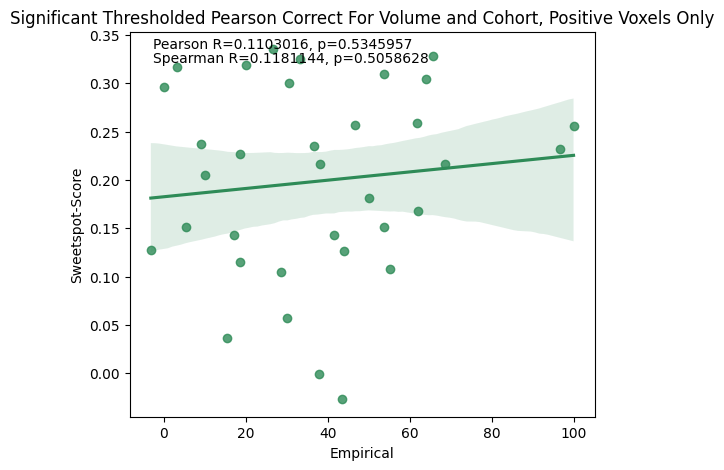

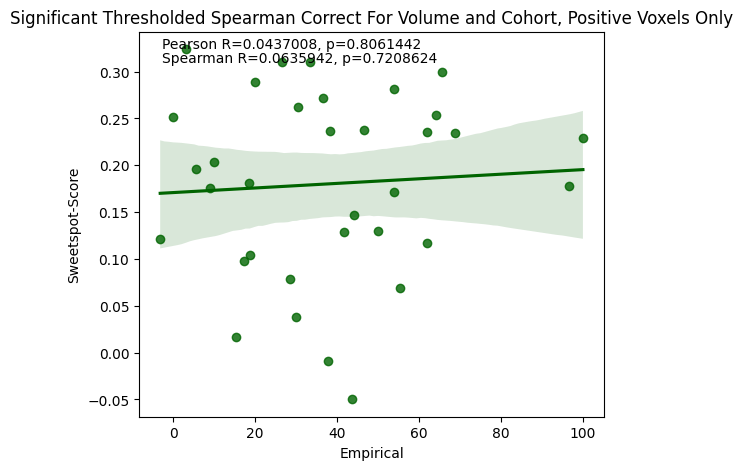

In [59]:
#method 1
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,save_path=None):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_analysis(df_column, control_pearson_r, 'Significant Thresholded Pearson Correct For Volume and Cohort, Positive Voxels Only', control_pearson_r_val, control_pearson_p_val, s_control_pearson_r_val, s_control_pearson_p_val, 'seagreen','/Volumes/Cingulate/Sweetspot_Seg/Outputs/python cross-validations/correct for volume&cohort/method1_pearson.png')
plot_analysis(df_column, control_spearman_r, 'Significant Thresholded Spearman Correct For Volume and Cohort, Positive Voxels Only', control_spearman_r_val, control_spearman_p_val, p_control_spearman_r_val, p_control_spearman_p_val, 'darkgreen','/Volumes/Cingulate/Sweetspot_Seg/Outputs/python cross-validations/correct for volume&cohort/method1_spearman.png')

# Control for Volume and Cohort Method 2

In [54]:
#generate and fit model
def model(df,corr_type):
    control_pearson_r,control_spearman_r = np.zeros(df.shape[0]),np.zeros(df.shape[0])
    pr_array,sr_array = np.zeros(df.shape[0]),np.zeros(df.shape[0])
    if corr_type == 'pearson' or corr_type == 'both':
        pearson_model = smf.ols('Pearson_Score ~ Volume + C(Cohort)', data=df).fit()
        print('Pearson:',pearson_model.summary())
        print()
        
        #correlate residuals and clinical outcomes
        for i in range(df.shape[0]):
            pearson_residuals = pearson_model.resid.values[i]
            pr_array[i] = pearson_residuals
            control_pearson_r[i],p = pearsonr(pr_array,df_column)
    
        #overall r and p
        control_pearson_r_val,control_pearson_p_val = pearsonr(control_pearson_r,df_column)
        s_control_pearson_r_val,s_control_pearson_p_val = spearmanr(control_pearson_r,df_column)

    if corr_type == 'spearman' or corr_type == 'both':
        spearman_model = smf.ols('Spearman_Score ~ Volume + C(Cohort)', data=df).fit()
        print('Spearman:',spearman_model.summary())
        
        #correlate residuals and clinical outcomes
        for i in range(df.shape[0]):
            spearman_residuals = spearman_model.resid.values[i]
            sr_array[i] = spearman_residuals
            control_spearman_r[i],p = spearmanr(sr_array,df_column)
        
        #overall r and p
        control_spearman_r_val,control_spearman_p_val = spearmanr(control_spearman_r,df_column)
        p_control_spearman_r_val,p_control_spearman_p_val = pearsonr(control_spearman_r,df_column)
    
    return pearson_residuals, spearman_residuals, control_pearson_r,control_spearman_r,control_pearson_r_val,control_pearson_p_val,control_spearman_r_val,control_spearman_p_val,s_control_pearson_r_val,s_control_pearson_p_val,p_control_spearman_r_val,p_control_spearman_p_val

df = pd.read_csv('/Volumes/Cingulate/Sweetspot_Seg/method2.csv')
corr_type == 'both'
pearson_residuals, spearman_residuals,control_pearson_r,control_spearman_r,control_pearson_r_val,control_pearson_p_val,control_spearman_r_val,control_spearman_p_val,s_control_pearson_r_val,s_control_pearson_p_val,p_control_spearman_r_val,p_control_spearman_p_val = model(df,corr_type)

Pearson:                             OLS Regression Results                            
Dep. Variable:          Pearson_Score   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     4.012
Date:                Wed, 27 Mar 2024   Prob (F-statistic):             0.0163
Time:                        17:59:52   Log-Likelihood:                -62.764
No. Observations:                  34   AIC:                             133.5
Df Residuals:                      30   BIC:                             139.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0498      0.92

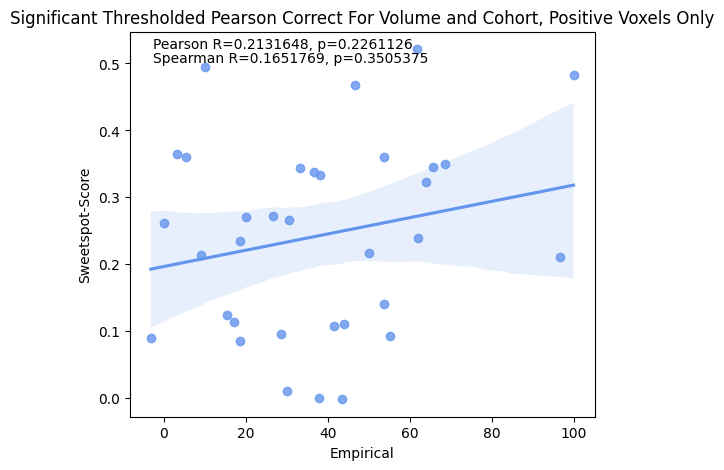

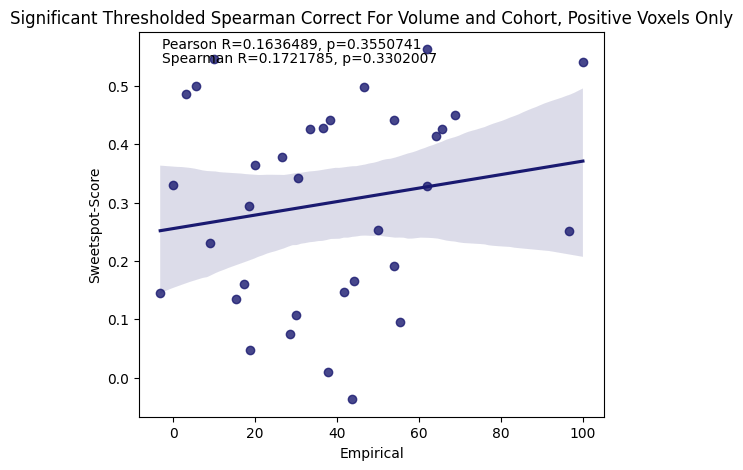

In [57]:
#method 2
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,save_path=None):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_analysis(df_column, control_pearson_r, 'Significant Thresholded Pearson Correct For Volume and Cohort, Positive Voxels Only', control_pearson_r_val, control_pearson_p_val, s_control_pearson_r_val, s_control_pearson_p_val, 'cornflowerblue','/Volumes/Cingulate/Sweetspot_Seg/Outputs/python cross-validations/correct for volume&cohort/method2_pearson.png')
plot_analysis(df_column, control_spearman_r, 'Significant Thresholded Spearman Correct For Volume and Cohort, Positive Voxels Only', control_spearman_r_val, control_spearman_p_val, p_control_spearman_r_val, p_control_spearman_p_val, 'midnightblue','/Volumes/Cingulate/Sweetspot_Seg/Outputs/python cross-validations/correct for volume&cohort/method2_spearman.png')